# py0xcluster

py0xCluster is a package dedicated to perform exploratory data analysis and machine learning tasks on DEX activity (Decentralized Exhanges) and web3 data.

This is for now an educational project for myself with the aim of performing fun data-science projects around blockchain data gathered through the Graph Network (https://thegraph.com/)

## Target objectives

- Establish meaningful grouping of address by clustering DEX traders and LP
    - Feature Extraction:
        - TBD but based on mint/swap/burn data from messari subgraphs entities
        - with or without balances at swap time (web3py fetch balance at block)
        - EOA vs Contracts
    - Dimensionality reduction:
        - UMAP / tSNE or PCA / ICA
    - Clustering:
        - DBSCAN
        - silhouette evaluation
    - Visualization:
        - scatter plot with color-coded returns? (TBD)

## Secondary objective: identify which group has the most profitable activity

- Triggered Average of price by swap in/out by group of addresses

- Predict future returns based on the activity of previously clustered groups of addresses

## ML overall approach:

- Decide whether adopting time-series vs tabular approach (preference for the first one)
- Compute time-series based on extracted features and certain kernels / windowing
- Begin by classification approach of expected future (down-bad / neurtral / up-strong)
- Extend to regression

## Random list of potential features:

### Accounts

### Relative to a pool:
- z-scored (clarify how) difference of price 24h? after swap -> could be target independant variable

- nb of events (z-scored to other addresses on same pool)
- average swap size (z-scored/pool)
- average deposit size (z-scored/pool)
- average withdraw size (z-score/pool)

### Account only

- Total nb of positions: swapCount, depositCount, withdrawCount
- ratio? of nb of: swaps / (deposits + withdraws)

### Account - Position
- nb of (liquid) pools interacted with
- % of events (likely swaps) happening in the same block (possibly identical to MEV bots?)
- % of Limit order on uni-v3 (one deposit amout = 0)

### Account - Web3

- is contract?
- Normalized balance (compared to other users) at time of events

# Roadmap:

## Easy / To implement first

### Aggregation / Feature computation

- Aggregate unique addresses
- Implement Account-only query
- First Web3 requests (is_contract / ETH balance)

### First plots

- First features distribution
- PCA/ICA -> t-SNE

## Next, not immediate priority

- Pool clustering / identify easy-best features

### Data Management

- Store/Retrieve to/from SQLite?
- Consider parquet / feather / hdf5

## Secondary, nice to do

### Package

- Update and test requirements / setup
- Document classes and methods with nicely formatted docstrings to future build of the doc

### Performance

- Evaluate performance, profiling, and try improving inefficient / slow bits

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from py0xcluster.main_classes.pools import PoolSelector
from py0xcluster.main_classes.pool_events import PoolEventGetter

from py0xcluster.features.swaps_feature_extractors import *

### Gathering data about most-active pools

In [14]:
from pathlib import Path

queries_folder = Path.cwd().parent / 'py0xcluster/queries'

uni3pools_selector = PoolSelector(
    subgraph_url = 'https://api.thegraph.com/subgraphs/name/revert-finance/uniswap-v3-bnb',
    query_file_path = queries_folder / 'revert_getTargetPools.gql',
    min_vol = 500,
    max_vol = 1000000,
    min_TVL = 500,
    max_TVL = 100000,
    min_fees = 0,
    min_mintburnUSD = 100,
    start_date = (2024,1,31), 
    end_date = (2024,2,3),
    days_batch_size = 20)

uni3_pools = uni3pools_selector.create_pool_selection(stables='exclude', verbose=True)
uni3_pools.pools_df.head(5)

Queriying from 2024-01-31 00:00:00 to 2024-02-03 00:00:00


KeyError: 'pool.inputTokens'

## Extracting all events from these pools

### Steps

- Data query:
    - Perform query for each pool, batch by days to accomodate response limit
    - Alternatively the query can be done on multiple pools. Ideally, the size of the batch should be proportional to the volume, but quite arbitrary to implement.
    - Consider whether do swaps / mints / burns separately or jointly
    - Loop and aggregate over days / pools (or batch of pools)


In [3]:
uni3_pools.pools_df.tail(30)

,pool.name,dailyVolumeUSD,pool.totalValueLockedUSD,token0.lastPriceUSD,token1.lastPriceUSD,pool.protocol.name,pool.protocol.network,pool.id,token0.symbol,token0.decimals,token1.symbol,token1.decimals
57,Uniswap V3 Pirex Ether/Wrapped Ether 0.01%,827276.355365,1.852989e+06,3.370231e+03,3307.837427,Uniswap V3,MAINNET,0x02edd21f1db8eb146be60998e9801691e725f119,pxETH,18,WETH,18
58,Uniswap V3 aleph.im v2/Wrapped Ether 1%,821697.240614,3.022534e+06,3.471263e-01,3307.837427,Uniswap V3,MAINNET,0xb38cc8c5f6eebc03a38515e2aad580e0b80d67ea,ALEPH,18,WETH,18
59,Uniswap V3 Wrapped Pulse from PulseChain/Wrapp...,779185.915589,6.139806e+06,1.323027e-04,3307.837427,Uniswap V3,MAINNET,0x4a2987c255ad7f9409c54a4fce7823441e14f08b,WPLS,18,WETH,18
60,Uniswap V3 Wrapped Ether/BTRFLY 1%,773882.214352,8.643400e+06,3.307837e+03,387.338952,Uniswap V3,MAINNET,0x3e6e23198679419cd73bb6376518dcc5168c8260,WETH,18,BTRFLY,18
61,Uniswap V3 Wrapped Balance AI/USD Coin 1%,765639.174769,3.792702e+06,8.084383e+00,1.000000,Uniswap V3,MAINNET,0x11f851639dd46a07f178e81ee1b234e91fd89c97,wBAI,9,USDC,6
62,Uniswap V3 Quant/Wrapped Ether 0.3%,760141.380181,1.522839e+06,1.077738e+02,3307.837427,Uniswap V3,MAINNET,0x24ee2c6b9597f035088cda8575e9d5e15a84b9df,QNT,18,WETH,18
63,Uniswap V3 KIZUNA/Wrapped Ether 1%,741705.137366,8.582554e+05,4.359389e-08,3307.837427,Uniswap V3,MAINNET,0xb7f27e5ebf97d88f37e16eddecc59523361a60e1,KIZUNA,18,WETH,18
64,Uniswap V3 ApeCoin/Wrapped Ether 0.3%,735924.617290,1.642491e+06,1.845789e+00,3307.837427,Uniswap V3,MAINNET,0xac4b3dacb91461209ae9d41ec517c2b9cb1b7daf,APE,18,WETH,18
65,Uniswap V3 Wrapped Ether/Rocket Pool Protocol ...,734769.633641,1.045391e+07,3.307837e+03,31.524373,Uniswap V3,MAINNET,0xe42318ea3b998e8355a3da364eb9d48ec725eb45,WETH,18,RPL,18
66,Uniswap V3 Bitcoin Cats/Wrapped Ether 1%,729308.155278,8.136652e+06,7.504081e-03,3307.837427,Uniswap V3,MAINNET,0xae790e2a4785298cb18150f3dc4a60bd81fcd274,1CAT,18,WETH,18


In [7]:
uni3_pools.pools_df['pool.id'].values

<StringArray>
['0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
 '0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b',
 '0x11b815efb8f581194ae79006d24e0d814b7697f6',
 '0x331399c614ca67dee86733e5a2fba40dbb16827c',
 '0x4585fe77225b41b697c938b018e2ac67ac5a20c0',
 '0x109830a1aaad605bbf02a9dfa7b0b92ec2fb7daa',
 '0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8',
 '0x9a772018fbd77fcd2d25657e5c547baff3fd7d16',
 '0xdf71525e5c7435ef860909547d1589e53c004f03',
 '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36',
 '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed',
 '0x60594a405d53811d3bc4766596efd80fd545a270',
 '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8',
 '0x19fe9857bb3652e9007f2347a1f877ffa9215f7f',
 '0xc64350c0eab6faed8f17cc2cdff0761c53fb4152',
 '0x11950d141ecb863f01007add7d1a342041227b58',
 '0x553e9c493678d8606d6a5ba284643db2110df823',
 '0x7b1e5d984a43ee732de195628d20d05cfabc3cc7',
 '0xad9ef19e289dcbc9ab27b83d2df53cdeff60f02d',
 '0xf763bb342eb3d23c02ccb86312422fe0c1c17e94',
 '0xa4e0faa58465a2d369aa21b3e42d43374c6f9613',

In [20]:
uni3_pools

PoolsRegister(pools_df=                                         pool.name  dailyVolumeUSD  \
0          Uniswap V3 USD Coin/Wrapped Ether 0.05%    1.801845e+08   
1        Uniswap V3 Wrapped Ether/Tether USD 0.01%    1.430418e+08   
2        Uniswap V3 Wrapped Ether/Tether USD 0.05%    6.434262e+07   
3             Uniswap V3 PepeFork/Wrapped Ether 1%    5.280104e+07   
4       Uniswap V3 Wrapped BTC/Wrapped Ether 0.05%    3.273897e+07   
..                                             ...             ...   
84        Uniswap V3 ChainLink Token/USD Coin 0.3%    5.521762e+05   
85  Uniswap V3 Alephium (AlphBridge)/Tether USD 1%    5.404983e+05   
86           Uniswap V3 Rollbit Coin/USD Coin 0.3%    5.322488e+05   
87           Uniswap V3 RabbitX/Wrapped Ether 0.3%    5.205688e+05   
88         Uniswap V3 Wrapped NXM/Wrapped Ether 1%    5.053611e+05   

    pool.totalValueLockedUSD  token0.lastPriceUSD  token1.lastPriceUSD  \
0               1.464708e+08         1.000000e+00          231

In [25]:
uni3_events_getter = PoolEventGetter(
    subgraph_url = 'https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum',
    query_file_path = queries_folder / 'messari_getPoolEvents.gql',
    pools_data = None,
    pool_ids = uni3_pools.pools_df['pool.id'].values[:5],#uni3_pools.pools_df['pool.id'].values[0],
    start_date = (2024,2,1), 
    end_date = (2024,2,3),
    days_batch_size = 1
    )

# Get swaps, deposits, and withdraw from a pool.
uni3_events = uni3_events_getter.get_events(verbose=True)


pool nb 0/5: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
Queriying from 2024-02-01 00:00:00 to 2024-02-02 00:00:00
Queriying from 2024-02-02 00:00:00 to 2024-02-03 00:00:00


AttributeError: 'NoneType' object has no attribute 'pools_df'

In [14]:
uni3_pools.pools_df

,pool.name,dailyVolumeUSD,pool.totalValueLockedUSD,token0.lastPriceUSD,token1.lastPriceUSD,pool.protocol.name,pool.protocol.network,pool.id,token0.symbol,token0.decimals,token1.symbol,token1.decimals
0,Uniswap V3 USD Coin/Wrapped Ether 0.05%,3.766707e+08,1.464317e+08,1.000000,2310.877056,Uniswap V3,MAINNET,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC,6,WETH,18
1,Uniswap V3 Wrapped Ether/Tether USD 0.05%,4.025901e+07,3.097347e+07,2310.877056,1.000000,Uniswap V3,MAINNET,0x11b815efb8f581194ae79006d24e0d814b7697f6,WETH,18,USDT,6
2,Uniswap V3 Wrapped BTC/Wrapped Ether 0.05%,3.984859e+07,6.944586e+07,43050.280517,2310.877056,Uniswap V3,MAINNET,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,WBTC,8,WETH,18
3,Uniswap V3 USD Coin/Wrapped Ether 0.3%,2.152343e+07,6.451183e+07,1.000000,2310.877056,Uniswap V3,MAINNET,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC,6,WETH,18
4,Uniswap V3 Lido DAO Token/Wrapped Ether 0.3%,1.386779e+07,9.940999e+06,2.816588,2310.877056,Uniswap V3,MAINNET,0xa3f558aebaecaf0e11ca4b2199cc5ed341edfd74,LDO,18,WETH,18
...,...,...,...,...,...,...,...,...,...,...,...,...
89,Uniswap V3 Wrapped Ether/Data Lake Token 0.3%,5.621955e+05,5.467356e+05,2310.877056,0.019557,Uniswap V3,MAINNET,0xefd69f1ff464ed673dab856c5b9bca4d2847a74f,WETH,18,LAKE,18
90,Uniswap V3 IMPT/Wrapped Ether 0.3%,5.322040e+05,8.975836e+05,0.004186,2310.877056,Uniswap V3,MAINNET,0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b,IMPT,18,WETH,18
91,Uniswap V3 Lyra Token/Wrapped Ether 1%,5.263315e+05,1.235739e+06,0.115756,2310.877056,Uniswap V3,MAINNET,0x3012e36cc30eb7ed916b8d4b82750b39551874dc,LYRA,18,WETH,18
92,Uniswap V3 Numeraire/Wrapped Ether 1%,5.082511e+05,8.887276e+05,23.016915,2310.877056,Uniswap V3,MAINNET,0x8df016708a66377dae191ca6f9fff4705a3d951f,NMR,18,WETH,18


In [13]:
uni3_events.swaps

In [8]:
non_unique_swaps_index = uni3_events.swaps.groupby(['pool.id','account.id']).count().id != 0
non_unique_swaps_index.index

C:\Users\jcarponc\AppData\Local\Temp\ipykernel_28228\1097299683.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  non_unique_swaps_index = uni3_events.swaps.groupby(['pool.id','account.id']).count().id != 0


MultiIndex([('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ...
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
            ('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', ...),
         

## Computation of features and aggregation by account.id

In [ ]:
# Features from swaps

uni3_events.swaps = compute_slippage(uni3_events.swaps)

uni3_events.swaps = uni3_events.swaps.round(2)

uni3_events.swaps = compute_zscore(
    uni3_events.swaps, 
    columns= ['amountInUSD', 'amountOutUSD', 'slippage'],
    group_by= 'pool.id')

# uni3_events.swaps = same_from_to(uni3_events.swaps, to_float=True)

addresses_swaps_features = aggregate_features(uni3_events.swaps, methods = ['median','mean','min','max','count'],
    columns = ['amountInUSD.zscore', 'slippage.zscore'],
    group_by = 'account.id')

# Tidy up useless columns            
addresses_swaps_features.drop(
    columns=['slippage.zscore.count', 'amountInUSD.zscore.count'], inplace=True)

addresses_swaps_features.rename(columns={'account.id':'tx.count'},inplace=True)





In [14]:
# Features from deposits
uni3_events.deposits = compute_zscore(
    uni3_events.deposits, 
    columns=['amountUSD', 'InputTokenAmount0', 'InputTokenAmount1'], 
    group_by= 'pool.id')

# uni3_events.deposits = same_from_to(uni3_events.deposits, to_float=True)

uni3_events.deposits = find_limit_orders(uni3_events.deposits)

addresses_deposits_features = aggregate_features(uni3_events.deposits, 
    methods = ['median','mean','min','max','count'],
    columns = ['amountUSD.zscore', 'is_limit_order'],
    group_by = 'account.id')

# Tidy up useless columns            
addresses_deposits_features.drop(
    columns=['is_limit_order.min', 'is_limit_order.max',
    'is_limit_order.median', 'is_limit_order.count', 'amountUSD.zscore.count'], inplace=True)

addresses_deposits_features.rename(columns={'account.id':'tx.count'},inplace=True)

# Features from withdraws
uni3_events.withdraws = compute_zscore(
    uni3_events.withdraws, 
    columns=['amountUSD', 'InputTokenAmount0', 'InputTokenAmount1'], 
    group_by= 'pool.id')

# uni3_events.withdraws = same_from_to(uni3_events.withdraws, to_float=True)

addresses_withdraws_features = aggregate_features(uni3_events.withdraws, methods = ['median','mean','min','max','count'],
    columns = ['amountUSD.zscore', ],
            group_by = 'account.id')

# Tidy up useless columns            
addresses_withdraws_features.drop(
    columns=['amountUSD.zscore.count'], inplace=True)

addresses_withdraws_features.rename(columns={'account.id':'tx.count'},inplace=True)

c:\users\jcarponc\code\py0xcluster\py0xcluster\features\swaps_feature_extractors.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_object[f"{col}.zscore"] = df_object.groupby(group_by)[col].transform(lambda x: (x - x.mean()) / x.std())
c:\users\jcarponc\code\py0xcluster\py0xcluster\features\swaps_feature_extractors.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_object[f"{col}.zscore"] = df_object.groupby(group_by)[col].transform(lambda x: (x - x.mean()) / x.std())
c:\users\jcarponc\code\py0xcluster\py0xcluster\features\swaps_feature_extractors.py:61: FutureWarning: The default of observed=False

In [18]:
addresses_deposits_features.sort_values(by='amountUSD.zscore.median', ascending=False).head(50)

,amountUSD.zscore.median,amountUSD.zscore.mean,is_limit_order.mean,amountUSD.zscore.min,amountUSD.zscore.max
account.id,,,,,
0x6046945c5b5ef5933b8e73a98a6ad7bf3e031df7,2.983818,2.983818,0.00,2.983818,2.983818
0x9aab3f81604c683a1a0d14019fbfe15bef7aa1ee,2.418902,2.418902,0.00,2.418902,2.418902
0x43e4715ae093a4c86b5ecddb52216c4f879e9672,2.376959,2.376959,0.00,2.376959,2.376959
0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f,2.124140,2.124140,0.00,2.124140,2.124140
0xa5a13f62ce1113838e0d9b4559b8caf5f76463c0,2.059374,2.059374,0.00,2.059374,2.059374
0x0cac3d1a887206e0f6169222c4504301a8b4b993,1.839531,1.839531,0.00,1.785838,1.893224
0xfb9779477e5b4834bf2bc02dd29b97b344d0f700,1.764320,1.764320,0.00,1.764320,1.764320
0xeca2e2d894d19778939bd4dfc34d2a3c45e96456,1.653006,1.653006,0.00,1.653006,1.653006
0x4603180bbb8221157880afaa84638e0fc467738d,1.646765,1.646765,0.00,1.646765,1.646765


In [11]:
# sns.pairplot(addresses_swaps_features)

In [12]:

addresses_swaps_features.nunique()

amountInUSD.zscore.median    3619
slippage.zscore.median        356
amountInUSD.zscore.mean      3644
slippage.zscore.mean          594
amountInUSD.zscore.min       3554
slippage.zscore.min           207
amountInUSD.zscore.max       3583
slippage.zscore.max           196
dtype: int64

## Merging features from swaps, deposits and withdraws

In [9]:
address_features = addresses_swaps_features.join(addresses_deposits_features.join(
    addresses_withdraws_features, lsuffix='.deposits', rsuffix='.withdraws', how='outer'),
    lsuffix='.swaps', how='outer')

In [24]:
from sklearn.preprocessing import StandardScaler
import umap

addresses_swaps_features.dropna(inplace=True)

scaled_swaps = StandardScaler().fit_transform(addresses_swaps_features)

reducer = umap.UMAP(n_neighbors=1000, min_dist=0.5, n_components=2, metric='euclidean')

embedding_swaps = reducer.fit_transform(scaled_swaps)
embedding_swaps.shape

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: >

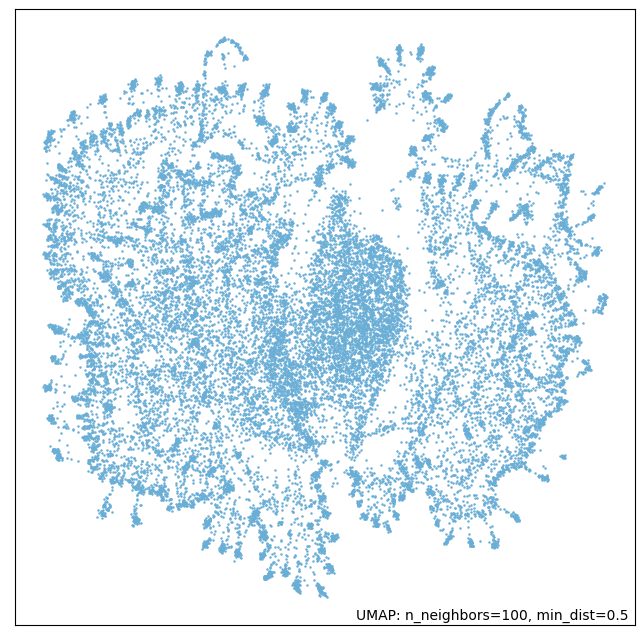

In [ ]:
import umap.plot
umap.plot.points(reducer)



<AxesSubplot: >

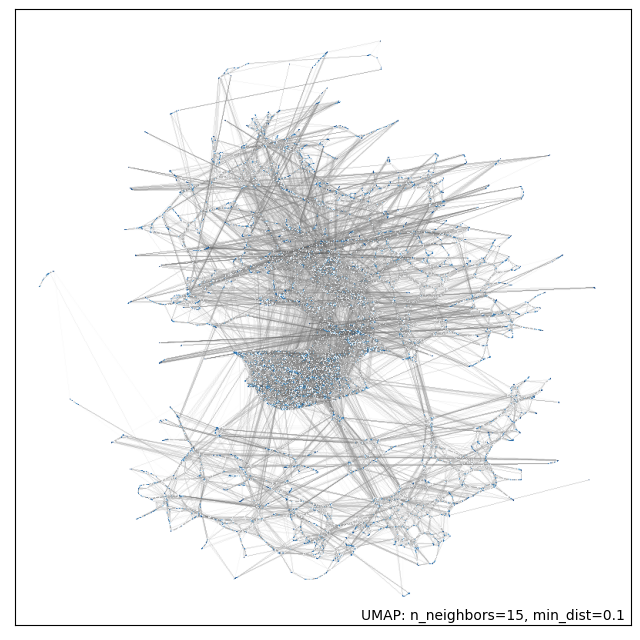

In [19]:
umap.plot.connectivity(reducer, show_points=True)

In [2]:
from web3 import Web3
from web3.beacon import Beacon

w3 = Web3(Web3.HTTPProvider('http://127.0.0.1:8545'))
w3.isConnected()
block = web3.eth.get_block('latest')
block['number']
web3.eth.syncing
beacon = Beacon("http://localhost:5052")
beacon.get_syncing()


/home/fujiju/anaconda3/envs/py0xcluster/lib/python3.8/site-packages/web3/beacon/__init__.py:4: UserWarning: Beacon node APIs are experimental and may not be implemented consistently by all clients.
  warnings.warn(


{'data': {'head_slot': '4463245',
  'sync_distance': '1196817',
  'is_syncing': True,
  'is_optimistic': False}}

In [ ]:
uni3_events.withdraws.to_pickle('/home/fujiju/Documents/GitHub/py0xcluster/data/20230117_215100_withdraws.pkl')

In [ ]:
deposits = pd.read_pickle('/home/fujiju/Documents/GitHub/py0xcluster/data/20230117_215100_deposits.pkl')

In [ ]:
import pickle
filename = '/home/fujiju/Documents/GitHub/py0xcluster/data/20230117_215800_all_events.pkl'
fileh = open(filename, 'w')
pickle.dump(uni3_events, fileh)

In [ ]:
uni3_events['swaps'].nunique()